In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from qampy.helpers import normalise_and_center as normcenter
from qampy.core.filter import rrcos_pulseshaping as lowpassFilter
from Funcoes import *

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['lines.linewidth'] = 2

In [51]:
M = 64        # ordem da modulação
Fb = 40e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs = SpS*Fb    # taxa de amostragem
SNR = 40        # relação sinal ruído (dB)
rolloff = 0.01  # Rolloff do filtro formatador de pulso
sfm = sinal_qam_fase_min(M,Fb,SpS,SNR)
ordem = 64
dataset , X , y = dataset_02(sfm,ordem)

In [52]:
X_train = X[:50000]
X_test = X[50000:]

y_train = y[:50000]
y_test = y[50000:]

In [53]:
scaler = MinMaxScaler()

In [54]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
stop = EarlyStopping(monitor='val_loss', patience=3)

In [56]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(ordem,)))
model.add(Dense(100, activation='relu'))
Dropout(0.5)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 16,701
Trainable params: 16,701
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, y_train, epochs=300, callbacks=[stop],
          validation_data=(X_test, y_test), batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
50000/50000 [==============================] - 9s 187us/sample - loss: 0.0076 - val_loss: 0.0037
Epoch 2/300
50000/50000 [==============================] - 7s 139us/sample - loss: 0.0021 - val_loss: 0.0019
Epoch 3/300
50000/50000 [==============================] - 7s 145us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 4/300
50000/50000 [==============================] - 8s 159us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 5/300
50000/50000 [==============================] - 8s 151us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 6/300
50000/50000 [==============================] - 7s 140us/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 7/300
50000/50000 [==============================] - 9s 173us/sample - loss: 0.0012 - val_loss: 0.0011
Epoch 8/300
50000/50000 [==============================] - 9s 171us/sample - loss: 0.0012 - val_loss: 9.5577e-04
Epoch 9/300
50000/50000 [==============================] - 8s 157us/sample

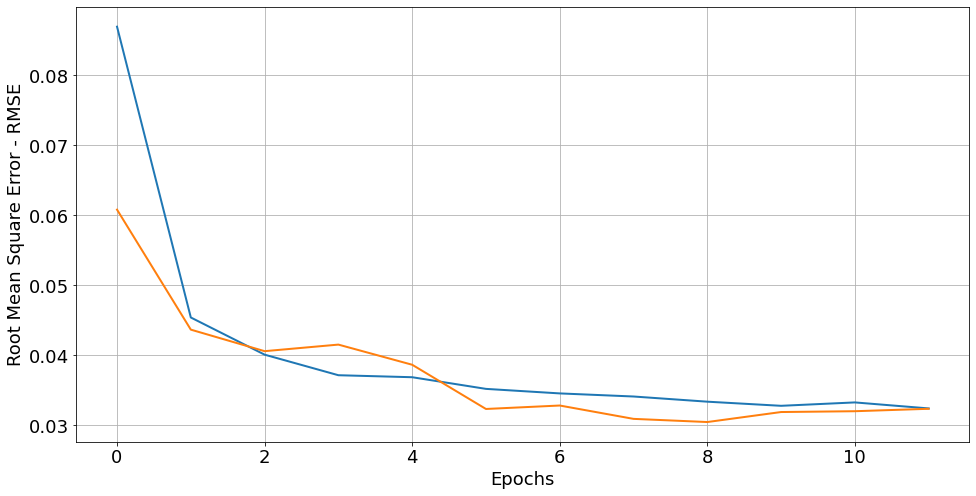

In [59]:
plt.plot(np.sqrt(model.history.history['loss']))
plt.plot(np.sqrt(model.history.history['val_loss']))
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error - RMSE')
plt.grid(True)

In [60]:
preds = model.predict(X_test)

In [61]:
print('rmse = ', np.sqrt(mean_squared_error(y_test, preds)))
print('r2 = ', r2_score(y_test, preds))

rmse =  0.0323559774674177
r2 =  0.9833224165724405


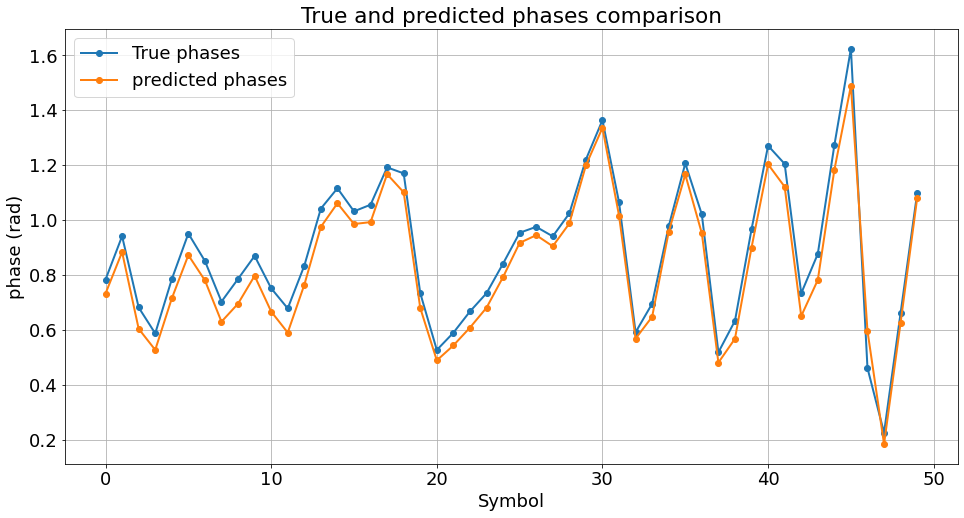

In [62]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[:50], '-o')
plt.plot(preds[:50], '-o')
plt.xlabel('Symbol')
plt.ylabel('phase (rad)')
plt.legend(['True phases', 'predicted phases'])
plt.title('True and predicted phases comparison')
plt.grid(True)
plt.show()

In [63]:
sinal = dataset['amplitudes'][50000:]*np.exp(1j*preds.reshape(-1,))

In [64]:
dataset['amplitudes'][50000:].shape

(10000,)

In [65]:
preds.shape

(10000, 1)

In [66]:
sinal.shape

(10000,)

In [67]:
sinal = sinal.reshape((1,-1))

In [68]:
sinal.shape

(1, 10000)

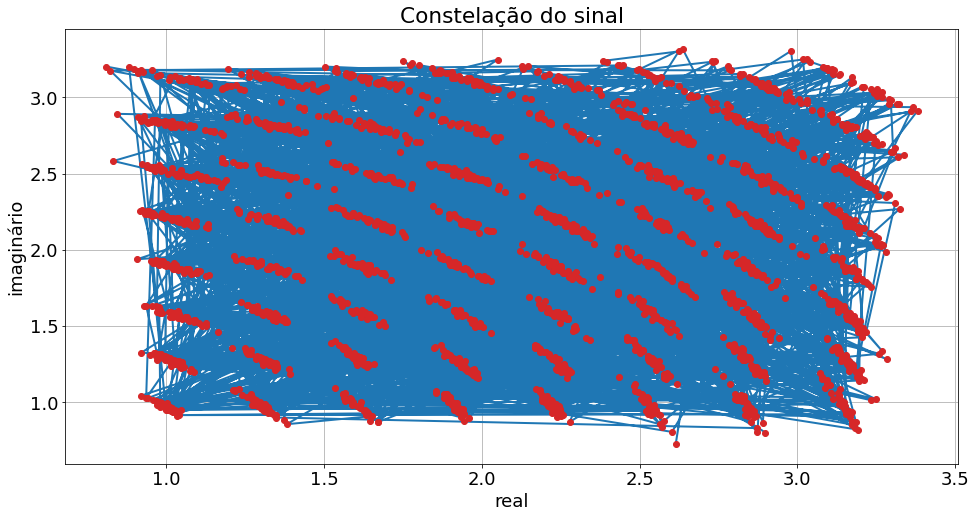

In [72]:
plot_constelação(sinal[:,::4])

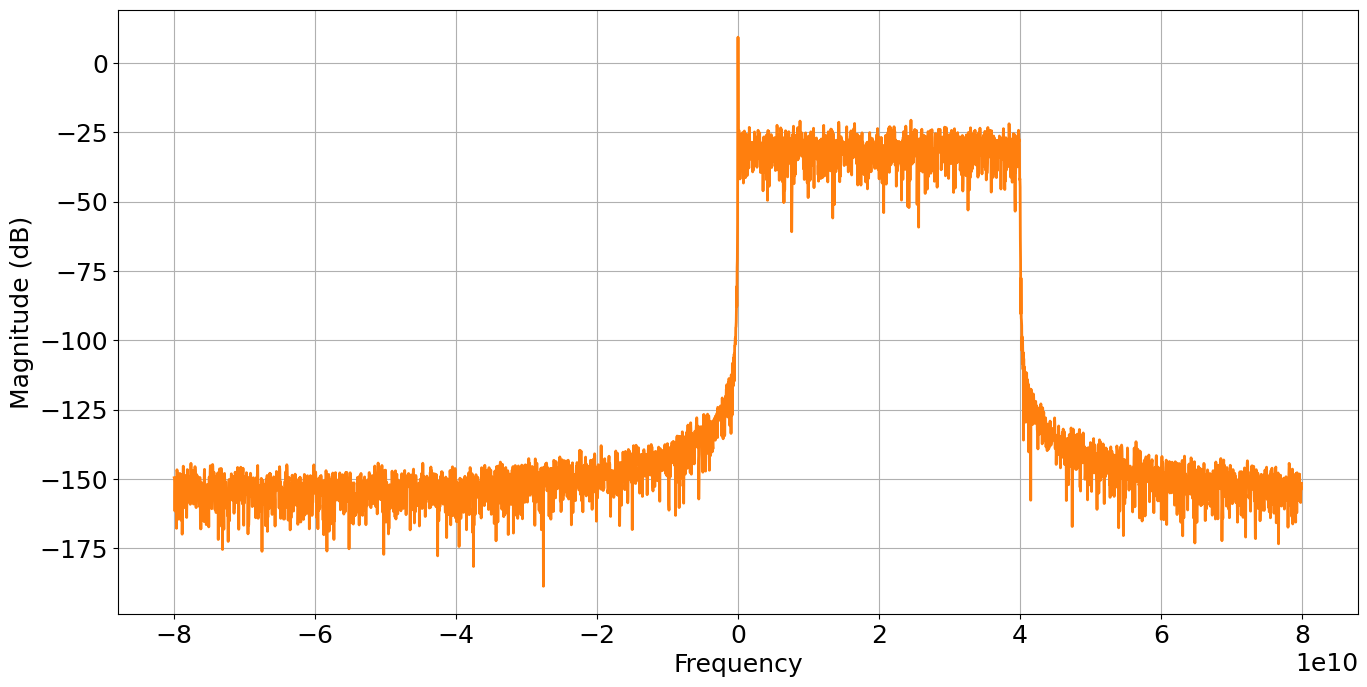

In [88]:
plot_espectro(sfm)

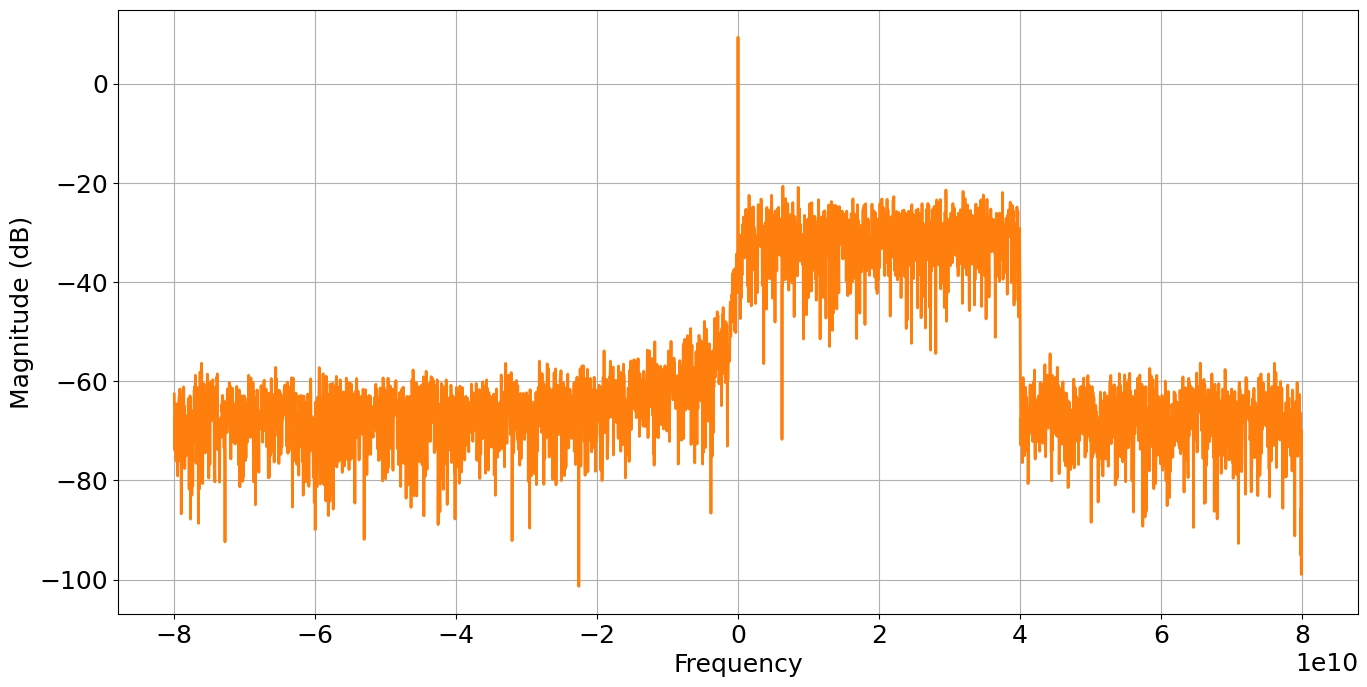

In [89]:
plot_espectro(sinal)

In [74]:
sinal_revertido = reverter_sinal_fase_min(sinal)

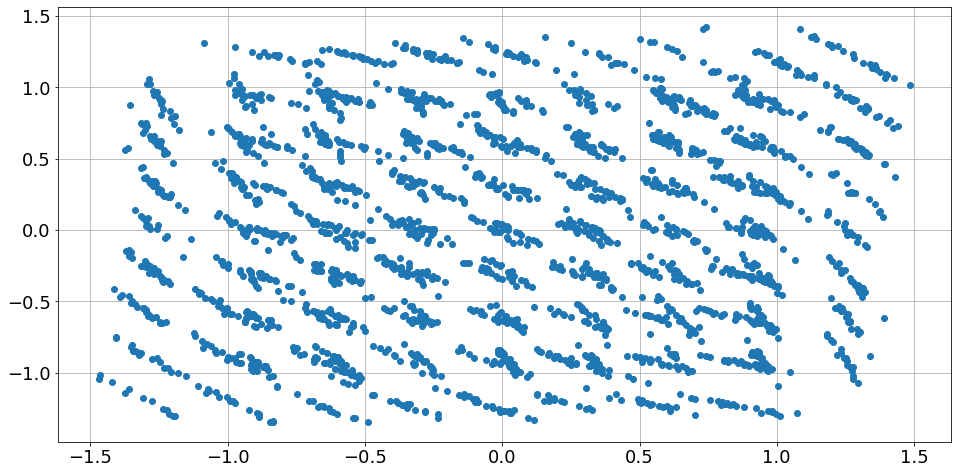

In [86]:
plt.plot(sinal_revertido[0,::4].real,sinal_revertido[0,::4].imag,'o');
plt.grid(True)
plt.show()

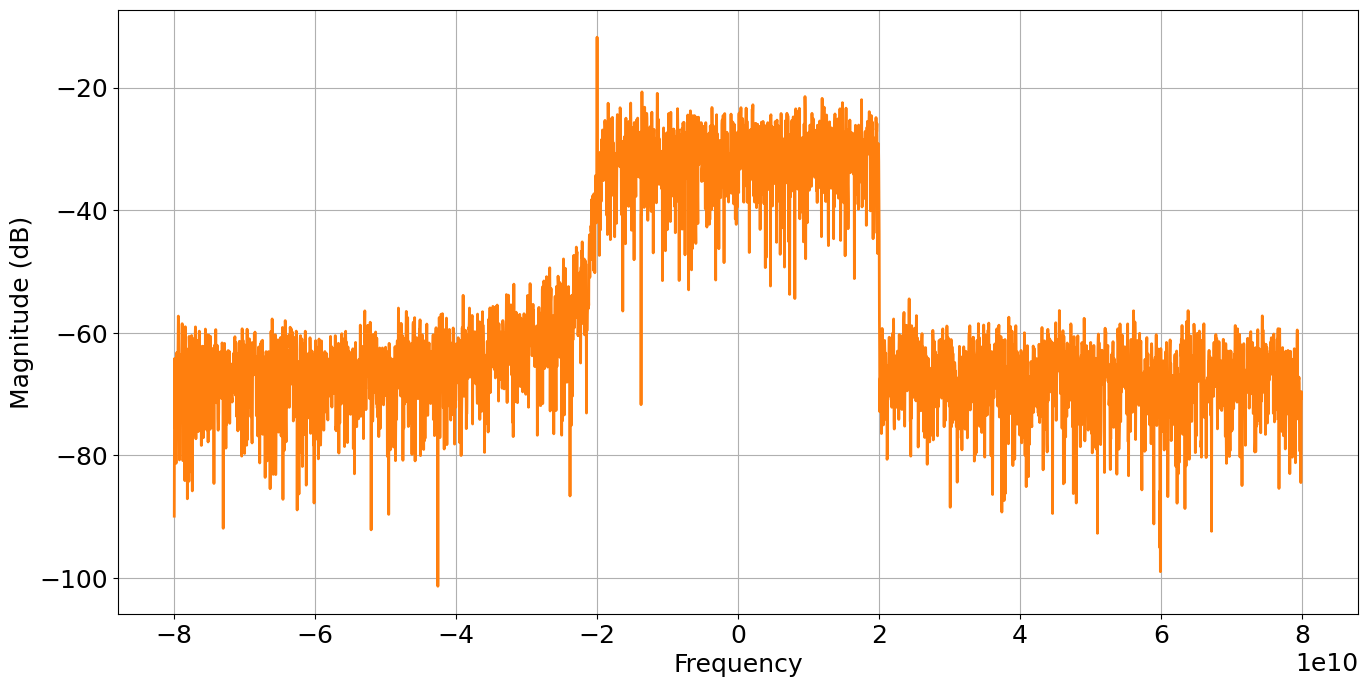

In [76]:
plot_espectro(sinal_revertido)

In [77]:
sfilt = normcenter(lowpassFilter(sinal_revertido, Fs, 1/Fb, 0.001, taps=4001))

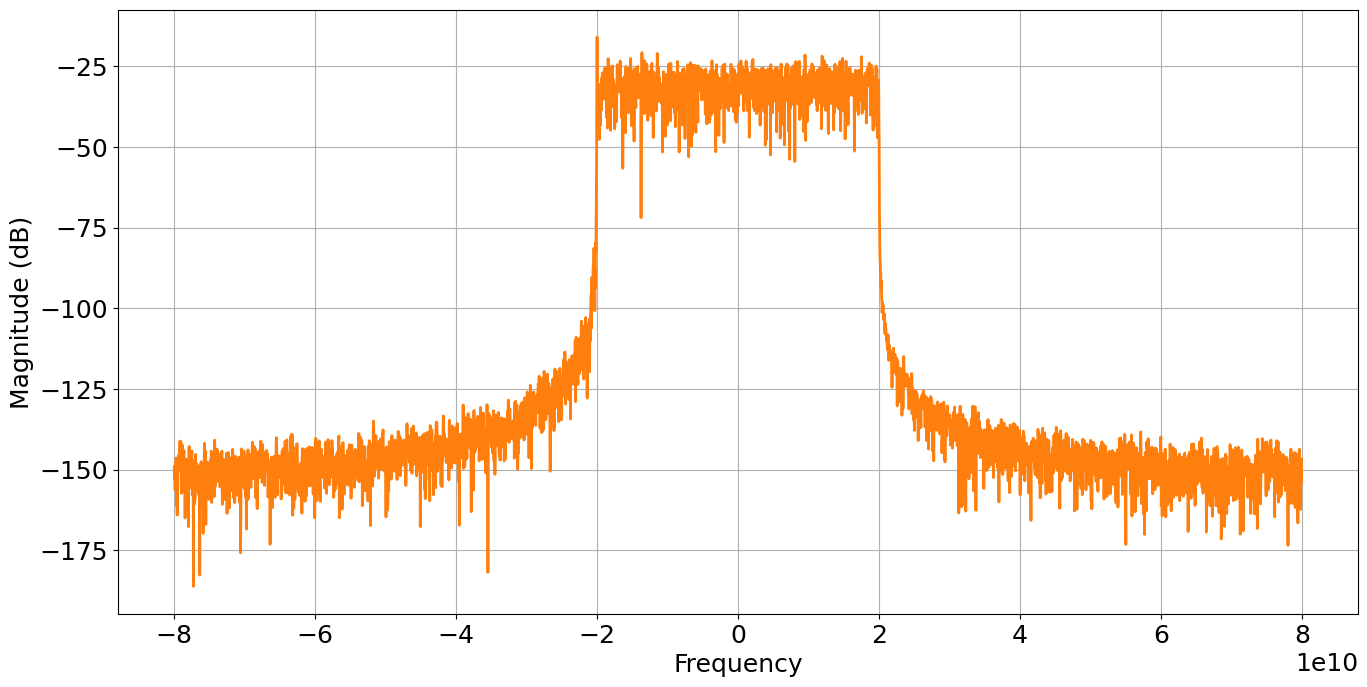

In [78]:
plot_espectro(sfilt)

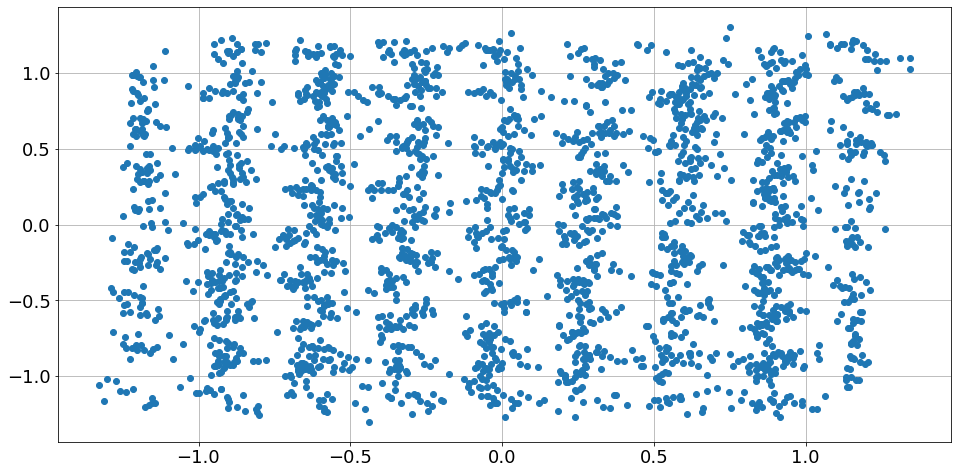

In [90]:
plt.plot(sfilt[0,::4].real,sfilt[0,::4].imag,'o');
plt.grid(True)
plt.show()

In [91]:
sfilt[0,::4].cal_ber()

array([0.05373333])

In [97]:
10*np.log10(sfilt[0,::4].est_snr())

array([15.69879654])